In [1]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import csv
import numpy as np
from matplotlib import pyplot as plt
from models.detector import face_detector
from models.parser import face_parser
from utils.visualize import show_parsing_with_annos

import tensorflow as tf
print(tf.__version__)

1.15.0
Using TensorFlow backend.


In [2]:
def resize_image(im, max_size=768):
    if np.max(im.shape) > max_size:
        ratio = max_size / np.max(im.shape)
        print(f"Resize image to ({str(int(im.shape[1]*ratio))}, {str(int(im.shape[0]*ratio))}).")
        return cv2.resize(im, (0,0), fx=ratio, fy=ratio)
    return im

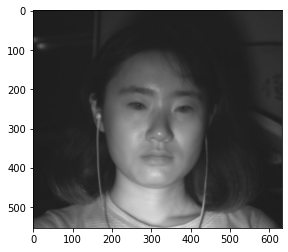

In [16]:
# 입력 이미지 불러오기
# Test images are obtained on https://www.pexels.com/
im = cv2.imread("./example.JPG")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

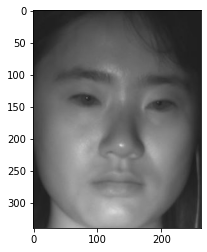

In [17]:
# 'str' object has no attribute 'decode'
# 라는 에러가 발생하면
# pip install h5py==2.10.0
# h5py 라이브러리가 버전 3일때 발생하는 에러로 2점대로 낮춰준다.
# 참고: https://beausty23.tistory.com/135

# face detector를 FAN, ELG 폴더에 있는 다양한 weight로 시도했으나 결과는 비슷함.
im = cv2.imread("./example.JPG")[..., ::-1]
fd = face_detector.FaceAlignmentDetector(lmd_weights_path="./models/detector/FAN/2DFAN-1_keras.h5")
bboxes = fd.detect_face(im, with_landmarks=False)
assert len(bboxes) > 0, "No face detected."

# Display detected face
x0, y0, x1, y1, score = bboxes[0] # show the first detected face
x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])

# 얼굴 bbox만 출력
plt.imshow(im[x0:x1, y0:y1, :])

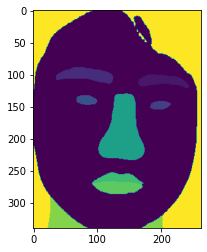

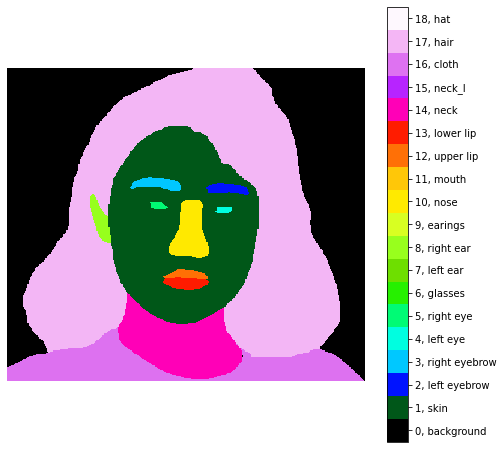

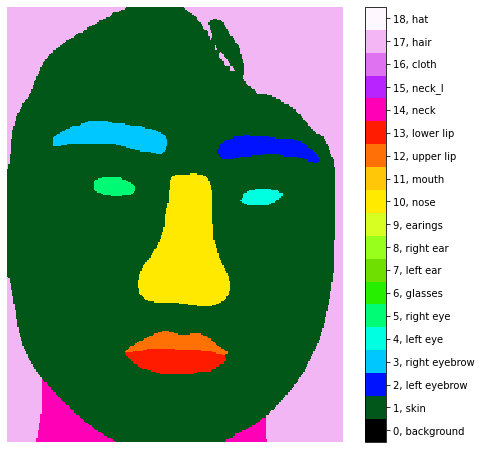

In [18]:
prs = face_parser.FaceParser()

# detection 없이 parsing
out = prs.parse_face(im)
out_face = prs.parse_face(im[x0:x1, y0:y1, :])
plt.imshow(out[0])
plt.imshow(out_face[0])
plt.imsave('result/parsing_big.jpg', out[0])  # 결과 이미지 저장
plt.imsave('result/parsing_small.jpg', out_face[0])

# Show parsing result with annotations
show_parsing_with_annos(out[0])
show_parsing_with_annos(out_face[0])

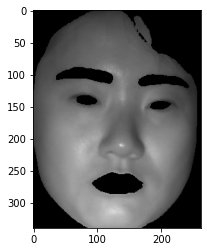

In [19]:
mask1 = [out_face[0] == 1]  # skin
mask2 = [out_face[0] == 10]  # nose
mask = np.logical_or(mask1, mask2)
mask=np.array(mask,dtype=np.uint8)

res = cv2.bitwise_and(im[x0:x1, y0:y1, :], im[x0:x1, y0:y1, :], mask = mask[0])
np.max(res)
plt.imshow(res)
# print(res)

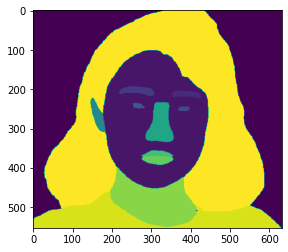

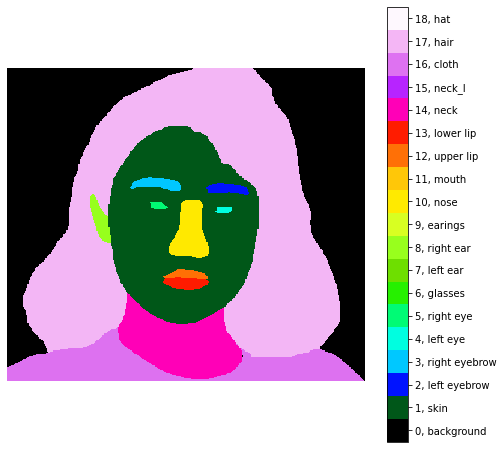

In [20]:
# parsing with detection
im = cv2.imread("./example.JPG")[..., ::-1]
im = resize_image(im) # Resize image to prevent GPU OOM.
h, w, _ = im.shape
plt.imshow(im)

# face detection
# Set detector into FaceParser
try:
    fd
except:
    from detector import face_detector
    fd = face_detector.FaceAlignmentDetector()
    
prs.set_detector(fd)
# prs.remove_detector()

# face parsing
out = prs.parse_face(im, with_detection=False)
#plt.figure(figsize=(15,8))
num_faces = len(out)
for i in range(num_faces):
    try:
        plt.subplot(1, num_faces, i+1)
        plt.imshow(out[i])
        show_parsing_with_annos(out[0])
    except:
        pass















mask shape:  (1, 553, 632)
saved skin img
skin shape:  (553, 632, 3)
피부 밝기 합:  7351089.0
피부 픽셀의 개수:  65671
얼굴 평균 밝기값: 111.938
csv 저장


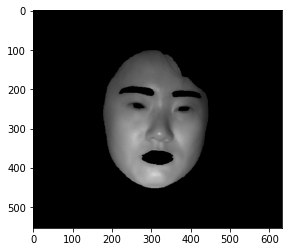

In [3]:

# face detection 수행
# 1) resize
im = cv2.imread("./example.JPG")[..., ::-1]
img = resize_image(im)  # Resize image to prevent GPU OOM.
h, w, _ = img.shape

# 2) face detection
fd = face_detector.FaceAlignmentDetector(lmd_weights_path="./models/detector/FAN/2DFAN-1_keras.h5")  # 1이 가장 속도가 빠름
bboxes = fd.detect_face(img, with_landmarks=False)
assert len(bboxes) > 0, "No face detected."

# # Display detected face
# x0, y0, x1, y1, score = bboxes[0] # show the first detected face
# x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
# face = img[x0:x1, y0:y1, :]
# # cv2.imwrite('res/face detection_'+frame+'.jpg', img[x0:x1, y0:y1, :])

# 3) face parsing(detection 없이)
face = img
prs = face_parser.FaceParser()
out = prs.parse_face(img)
out_face = prs.parse_face(face)

plt.imshow(out[0])
plt.imshow(out_face[0])
# plt.imsave('res/' + str(frame_num) + '_all.jpg', out[0])  # 결과 이미지 저장
# plt.imsave('res/' + str(frame_num) + '_face.jpg', out_face[0])

# Show parsing result with annotations
# show_parsing_with_annos(out[0])
# show_parsing_with_annos(out_face[0])


# 피부영역만 추출하기
mask1 = [out_face[0] == 1]  # skin
mask2 = [out_face[0] == 10]  # nose
mask = np.logical_or(mask1, mask2)

print("mask shape: ", np.shape(mask))
mask = np.array(mask, dtype=np.uint8)  # 피부면 1, 아니면 0이 들어있음
# res = cv2.bitwise_and(im[x0:x1, y0:y1, :], img[x0:x1, y0:y1, :], mask = mask[0])
skin = cv2.bitwise_and(face, face, mask = mask[0])


# plt.imsave('res/' + str(frame_num) + '_skin.jpg', skin)  # 피부영역 저장
# plt.imsave('res/' + str(frame_num) + '_mask.jpg', mask[0])
plt.imshow(skin)  
print("saved skin img")

print("skin shape: ", np.shape(skin))  # (H, W, 3), 적외선 영상도 RGB라서 3채널임
# print("mask shape: ", np.shape(mask))  # (1, H, W)
H = np.shape(skin)[0]  # 얼굴의 세로 길이
W = np.shape(skin)[1]  # 얼굴의 가로 길이
gray = cv2.cvtColor(skin, cv2.COLOR_BGR2GRAY)


# 간단하게 평균 밝기 구하기
skin_num = mask.sum()
skin_sum = skin.sum() / 3
mean = skin_sum / skin_num

print("피부 밝기 합: ", skin_sum)
print("피부 픽셀의 개수: ", skin_num)
print("얼굴 평균 밝기값: {:.3f}".format(mean))

# 얼굴 밝기값 저장
f = open('csv/ex.csv', 'a', newline='')
wr = csv.writer(f)
# wr.writerow([mean, round(au_occur[0], 3), round(au_occur[1], 3), round(au_occur[3], 3), round(au_occur[17], 3)])
wr.writerow([mean])
f.close()
print("csv 저장")

# 리소스 해제
cv2.destroyAllWindows()